In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [3]:
psg_file = "data/SC4001E0-PSG.edf"
psg_data = mne.io.read_raw_edf(psg_file)

Extracting EDF parameters from c:\Tum\5-AR-local\AprendizajeAutomatico\72.75-ML\final\data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
fs = psg_data.info.get('sfreq')
print(fs,'Hz')

data = psg_data.get_data()
data.shape

100.0 Hz


(7, 7950000)

In [5]:
secs = data.shape[1]/fs
print(f'{secs} segundos')
print(f'{secs/60} minutos')
print(f'{secs/60/60} horas')


print(psg_data.ch_names)
print(psg_data.get_channel_types())
print(len(psg_data['EEG Fpz-Cz'][0][0]))

79500.0 segundos
1325.0 minutos
22.083333333333332 horas
['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
7950000


In [6]:
len(psg_data['EEG Fpz-Cz'][0][0])
t = psg_data['EEG Fpz-Cz'][1]
t

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 7.949997e+04,
       7.949998e+04, 7.949999e+04])

In [7]:
print(psg_data.info.get('ch_names'))
EEG_Fpz_Cz, EEG_Pz_Oz, EOG_Horizontal, Resp_oro_nasal, EMG_submental, Temp_rectal, Event_marker= data[0], data[1], data[2], data[3], data[4], data[5], data[6]

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


In [8]:
#add annotations
hypnogramm_file = "data/SC4001EC-Hypnogram.edf"
hypnogramm_annotations = mne.read_annotations(hypnogramm_file)
psg_data.set_annotations(hypnogramm_annotations)


C:\Users\flo12\AppData\Local\Temp\ipykernel_18672\2458527308.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data.set_annotations(hypnogramm_annotations)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~13 kB, data not loaded>

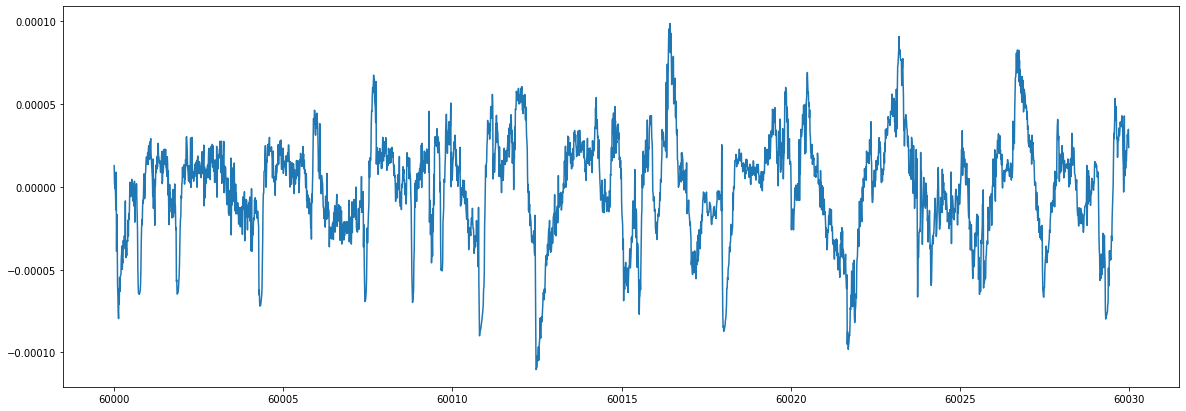

<Annotations | 1 segment: Sleep stage W (1)>

In [14]:
EPOCH_LENGTH = 30
epoch = 2000
plt.figure(figsize=(20,7))
plt.plot(t[int(epoch*EPOCH_LENGTH*fs):int((epoch + 1)*EPOCH_LENGTH*fs)]
         ,EEG_Fpz_Cz[int(epoch*EPOCH_LENGTH*fs):int((epoch + 1)*EPOCH_LENGTH*fs)])
plt.show()

start_datetime = psg_data.info['meas_date']
a = psg_data.annotations.copy().crop(
    start_datetime.timestamp() + epoch * EPOCH_LENGTH ,start_datetime.timestamp() + epoch * EPOCH_LENGTH + EPOCH_LENGTH )
a